<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Spaceship Titanic: EDA</h1>
</div>

**Problem Type:** Binary Classification

## Evaluation Metric


In [1]:
# Black formatter https://black.readthedocs.io/en/stable/

! pip install nb-black > /dev/null

%load_ext lab_black

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Import Libraries</h1>
</div>

In [2]:
import os
from pathlib import Path
import time
import gc

import random
import pandas as pd
import numpy as np
import datatable as dt  # Fast table loading

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Visualization Libraries
import matplotlib.pylab as plt
import seaborn as sns

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Configuration</h1>
</div>

In [3]:
class Config:
    path = "../input/spaceship-titanic"
    gpu = True
    debug = False
    optimize = True
    n_optimize_trials = 5
    model_type = "xgb"  # (xgb, cat, lgbm, keras)
    model_name = "xgb1"
    competition = "Spaceship Titanic"
    seed = 42
    N_ESTIMATORS = 100  # 100, 300, 2000, 5000

    batch_size = 64
    epochs = 25
    N_FOLDS = 15  # 5,10,15
    SEED_LENGTH = 1  # 5,10

In [4]:
TARGET = "Transported"
TARGET_ENC = "target_num"

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Library</h1>
</div>

In [5]:
def create_folds(df, TARGET, n_folds=5, seed=42):
    print(f"TARGET={TARGET}, n_folds={n_folds}, seed={seed}")
    df["fold"] = -1

    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    # kf = GroupKFold(n_splits=Config.N_FOLDS)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(df, df[TARGET])):
        df.loc[valid_idx, "fold"] = fold

    # df.to_csv(f"train_fold{num_folds}.csv", index=False)
    return df

In [6]:
def label_encoder(train, test, columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] = LabelEncoder().fit_transform(test[col])
    return train, test

In [7]:
def read_data(path):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    # train_df = dt.fread(data_dir / "train.csv").to_pandas()
    # test_df = dt.fread(data_dir / "test.csv").to_pandas()

    submission_df = pd.read_csv(data_dir / "sample_submission.csv")

    print(f"train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
    print(f"test data : Rows={test.shape[0]}, Columns={test.shape[1]}")
    return train, test, submission_df

In [8]:
def show_missing_features(df):
    missing_vals = df.isna().sum().sort_values(ascending=False)
    print(missing_vals[missing_vals > 0])

In [9]:
def show_missing_features_pct(df):
    nan = pd.DataFrame(
        df.isna().sum().sort_values(ascending=False), columns=["NaN_sum"]
    )
    nan["Percentage(%)"] = (nan["NaN_sum"] / len(df)) * 100
    nan = nan[nan["NaN_sum"] > 0]
    nan = nan.sort_values(by=["NaN_sum"])
    print(nan)

In [10]:
def missing_values(df):
    # Calculate missing value and their percentage for each feature
    missing_percent = df.isnull().sum() * 100 / df.shape[0]
    df_missing_percent = pd.DataFrame(missing_percent).round(2)
    df_missing_percent = df_missing_percent.reset_index().rename(
        columns={"index": "Feature", 0: "Missing Percentage (%)"}
    )
    df_missing_value = df.isnull().sum()
    df_missing_value = df_missing_value.reset_index().rename(
        columns={"index": "Feature", 0: "Missing Values"}
    )

    final = df_missing_value.merge(
        df_missing_percent, how="inner", left_on="Feature", right_on="Feature"
    )
    final = final.sort_values(by="Missing Percentage (%)", ascending=False)
    return final

In [11]:
def check_low_cardinality(df, features, threshold=25):
    low_cardinality = [col for col in features if df[col].nunique() < threshold]
    return low_cardinality

In [12]:
# OOF Results
if not os.path.exists("results"):
    os.makedirs("results")

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Load Train/Test Data</h1>
</div>

Support datatable for large datasets.
Using datatable is described in [Tutorial on reading datasets](https://www.kaggle.com/hiro5299834/tutorial-on-reading-datasets)

In [13]:
%%time
train, test, submission_df = read_data(Config.path)

train data: Rows=8693, Columns=14
test data : Rows=4277, Columns=13
CPU times: user 45.7 ms, sys: 13.2 ms, total: 58.9 ms
Wall time: 100 ms


In [14]:
train.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
6033,6380_01,Earth,False,F/1322/P,TRAPPIST-1e,37.0,False,0.0,959.0,8.0,20.0,169.0,Thel Fryersonis,False
8328,8891_02,Earth,False,F/1831/P,TRAPPIST-1e,16.0,False,0.0,1332.0,0.0,0.0,0.0,Isa Pooley,True
5405,5771_01,Earth,False,G/937/S,TRAPPIST-1e,47.0,False,0.0,868.0,0.0,4.0,NaN,Sanda Fielson,True
6733,7098_01,Earth,False,F/1356/S,TRAPPIST-1e,35.0,False,3.0,0.0,651.0,0.0,78.0,Joanny Guerson,True
263,0289_01,Europa,True,C/12/S,55 Cancri e,19.0,False,0.0,0.0,0.0,0.0,0.0,Furuson Objeciane,True


In [15]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [17]:
train[TARGET].unique()

array([False,  True])

In [18]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


In [19]:
train.describe(include=["float64"]).T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


In [20]:
# features with object and bool types
train.describe(include=[object, bool]).T

,count,unique,top,freq
PassengerId,8693,8693,0001_01,1
HomePlanet,8492,3,Earth,4602
CryoSleep,8476,2,False,5439
Cabin,8494,6560,G/734/S,8
Destination,8511,3,TRAPPIST-1e,5915
VIP,8490,2,False,8291
Name,8493,8473,Gollux Reedall,2
Transported,8693,2,True,4378


In [21]:
corr = train.corr()
corr.style.background_gradient(cmap="coolwarm")

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000


In [22]:
train[TARGET] = train[TARGET].replace({True: 1, False: 0})
train["VIP"] = train["VIP"].replace({True: 1, False: 0})  # .astype(int)
train["CryoSleep"] = train["CryoSleep"].replace({True: 1, False: 0})  # .astype(int)
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,0.0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,0.0,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,Europa,0.0,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0003_02,Europa,0.0,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,0004_01,Earth,0.0,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1


In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   float64
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   float64
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   int64  
dtypes: float64(8), int64(1), object(5)
memory usage: 950.9+ KB


In [24]:
%%time
# sns.pairplot(train, hue="Transported", height=3, diag_kind="hist")
# # sns.pairplot(train, height=3, diag_kind="hist")
# plt.show()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 7.15 µs


<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Missing Values</h1>
</div>

- https://www.kaggle.com/code/hamzaghanmi/let-s-use-keras-tensorflow

In [25]:
show_missing_features(train)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
dtype: int64


In [26]:
show_missing_features_pct(train)

              NaN_sum  Percentage(%)
Age               179       2.059128
RoomService       181       2.082135
Destination       182       2.093639
FoodCourt         183       2.105142
Spa               183       2.105142
VRDeck            188       2.162660
Cabin             199       2.289198
Name              200       2.300702
HomePlanet        201       2.312205
VIP               203       2.335212
ShoppingMall      208       2.392730
CryoSleep         217       2.496261


In [27]:
# Looking at NaN % within the train data
nan = pd.DataFrame(train.isna().sum(), columns=["NaN_sum"])
nan["Percentage(%)"] = (nan["NaN_sum"] / len(train)) * 100
nan = nan[nan["NaN_sum"] > 0]
nan = nan.sort_values(by=["NaN_sum"])
nan

,NaN_sum,Percentage(%)
Age,179,2.059128
RoomService,181,2.082135
Destination,182,2.093639
FoodCourt,183,2.105142
Spa,183,2.105142
VRDeck,188,2.162660
Cabin,199,2.289198
Name,200,2.300702
HomePlanet,201,2.312205
VIP,203,2.335212


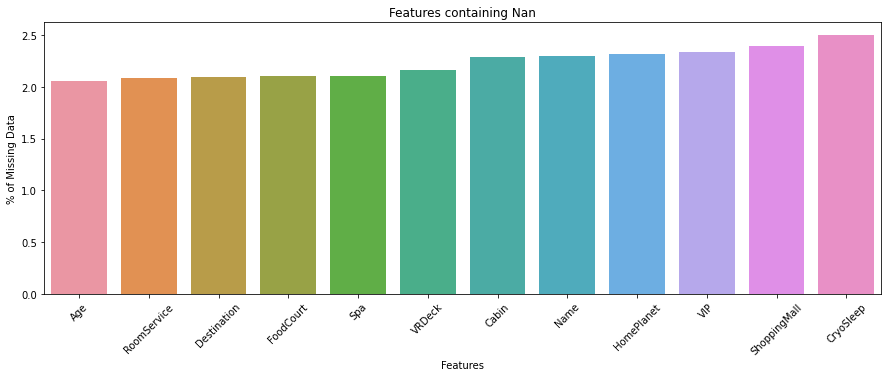

In [28]:
# Plotting Nan

plt.figure(figsize=(15, 5))
sns.barplot(x=nan.index, y=nan["Percentage(%)"])
plt.xticks(rotation=45)
plt.title("Features containing Nan")
plt.xlabel("Features")
plt.ylabel("% of Missing Data")
plt.show()

- https://www.kaggle.com/code/shilongzhuang/space-titanic-a-beginner-guide-80-24-accuracy

In [29]:
missing_values(train)

,Feature,Missing Values,Missing Percentage (%)
2,CryoSleep,217,2.50
9,ShoppingMall,208,2.39
6,VIP,203,2.34
1,HomePlanet,201,2.31
12,Name,200,2.30
3,Cabin,199,2.29
11,VRDeck,188,2.16
8,FoodCourt,183,2.11
10,Spa,183,2.11
4,Destination,182,2.09


In [30]:
missing_values(test)

,Feature,Missing Values,Missing Percentage (%)
8,FoodCourt,106,2.48
10,Spa,101,2.36
3,Cabin,100,2.34
9,ShoppingMall,98,2.29
12,Name,94,2.20
2,CryoSleep,93,2.17
6,VIP,93,2.17
4,Destination,92,2.15
5,Age,91,2.13
1,HomePlanet,87,2.03


In [31]:
## Separate Categorical and Numerical Features
cat_features = list(train.select_dtypes(include=["category", "object"]).columns)
num_features = list(test.select_dtypes(include=["number"]).columns)
cat_features.remove("PassengerId")

In [32]:
print(f"Categorical Features: {cat_features}")
print(f"Numerical Features: {num_features}")

Categorical Features: ['HomePlanet', 'Cabin', 'Destination', 'Name']
Numerical Features: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


In [33]:
train[cat_features].nunique()

HomePlanet        3
Cabin          6560
Destination       3
Name           8473
dtype: int64

In [34]:
train[num_features].nunique()

Age               80
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
dtype: int64

In [35]:
def show_cardinality(df, features):
    print(df[features].nunique())

In [36]:
show_cardinality(train, num_features)

Age               80
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
dtype: int64


In [37]:
# cat_col = [col for col in train.columns if train[col].nunique() < 4]
# cat_col

In [38]:
## Double check cardinality or numerical features.  Could be categorical features
cat_col = [col for col in num_features if train[col].nunique() < 25]
cat_col

[]

In [39]:
check_low_cardinality(train, cat_features, 25)

['HomePlanet', 'Destination']